# About 
This notebook analyzes Boer-Mulders from HERMES data.  The following options can be configured.
- Include HERMES data or not 
- Run single fit or nested sampling
- Fit Collins or use the SIA result

In [2]:
import copy 
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
import pylab as py
import sys

from fitlab.mcsamp import MCSAMP
from fitlab.maxlike import ML 
from fitlab.resman import RESMAN
from tools.config import load_config, conf
from tools.tools import load, save, checkdir

%matplotlib inline

In [3]:
if 'FITPACK' not in os.environ:
    print('Please set environment variable FITPACK to the root directory for this repo.')
else:
    print('Your FITPACK environment is %s' % os.environ['FITPACK'])

Your FITPACK environment is /home/dmriser/repos/fitpack


### Options Setup
The following cell is used to specify options that will be used in the notebook execution.

In [4]:
FIT_COLLINS  = False
FIT_TYPE     = 'nested'
path2results = 'sidis_boermulders_hermes'

### Library Instantiation and Setup
The following cells are used for setting up the datasets, parameters, and fitter.  The only changes necessary are to the fixed/free status of the parameters and their boundaries.

In [5]:
checkdir(path2results)
conf['datasets'] = {}

In [6]:
def setup_datasets(dataset_indices):
    conf['datasets']['sidis']={}
    conf['datasets']['sidis']['filters']={0:{'idx':None,'filter':None}}
    conf['datasets']['sidis']['filters'][0]['filter']='z<0.6 and Q2>1.69 and pT>0.2 and pT<0.9'

    conf['datasets']['sidis']['filters'][0]['idx'] = []
    for index in dataset_indices:
        conf['datasets']['sidis']['filters'][0]['idx'].append(index)

    conf['datasets']['sidis']['xlsx']={}
    for dataset_index in conf['datasets']['sidis']['filters'][0]['idx']:
        conf["datasets"]["sidis"]["xlsx"][dataset_index] = 'sidis/expdata/%d.xlsx' % dataset_index     

    conf['datasets']['sidis']['norm']={}
    for k in conf['datasets']['sidis']['xlsx']: 
        conf['datasets']['sidis']['norm'][k]={'value':1,'fixed':True,'min':0,'max':1} 

In [7]:
# These datasets are the HERMES data.
active_datasets = [5019, 5020, 5023, 5024]
print('Loading... ', active_datasets)

('Loading... ', [5019, 5020, 5023, 5024])


In [8]:
setup_datasets(active_datasets)

In [9]:
conf['params'] = {}
conf['shape']  = 1

In [10]:
def configure_collins_fixed():
    conf['params']['collins'] = {}
    conf['params']['collins']['widths0 pi+ fav']     = {'value':0.07249,'fixed':True,'min':1e-5,'max':1}
    conf['params']['collins']['widths0 pi+ unfav']   = {'value':0.10606,'fixed':True,'min':1e-5,'max':2}
    conf['params']['collins']['pi+ u N 1']  = {'value': 1.05988,'fixed':True,'min':0,'max':20}
    conf['params']['collins']['pi+ u a 1']  = {'value':-1.56637,'fixed':True,'min':-1,'max':5}
    conf['params']['collins']['pi+ u b 1']  = {'value': 4.76009 ,'fixed':True,'min':1e-5,'max':10}
    conf['params']['collins']['pi+ d N 1']  = {'value':-6.64443,'fixed':True,'min':-20,'max':0}
    conf['params']['collins']['pi+ d a 1']  = {'value': 3.45852,'fixed':True,'min':-1,'max':5}
    conf['params']['collins']['pi+ d b 1']  = {'value': 3.11503 ,'fixed':True,'min':1e-5,'max':10}
    conf['params']['collins']['pi+ u c 1']  = {'value': 0.0,'fixed':True,'min':-10,'max':10}
    conf['params']['collins']['pi+ d c 1']  = {'value': 0.0,'fixed':True,'min':-10,'max':10}
    conf['params']['collins']['pi+ u d 1']  = {'value': 0.0,'fixed':True,'min':-10,'max':10}
    conf['params']['collins']['pi+ d d 1']  = {'value': 0.0,'fixed':True,'min':-10,'max':10}

    conf['params']['collins']['pi+ u N 2']  = {'value': 8.64876,'fixed':True,'min':0,'max':20}
    conf['params']['collins']['pi+ u a 2']  = {'value': 4.31424,'fixed':True,'min':-1,'max':5}
    conf['params']['collins']['pi+ u b 2']  = {'value': 3.59918,'fixed':True,'min':1e-5,'max':10}
    conf['params']['collins']['pi+ d N 2']  = {'value': 0.0,'fixed':True,'min':-20,'max':0}
    conf['params']['collins']['pi+ d a 2']  = {'value': 0.0,'fixed':True,'min':-1,'max':5}
    conf['params']['collins']['pi+ d b 2']  = {'value': 0.0,'fixed':True,'min':1e-5,'max':10}
    conf['params']['collins']['pi+ u c 2']  = {'value': 0.0,'fixed':True,'min':-10,'max':10}
    conf['params']['collins']['pi+ d c 2']  = {'value': 0.0,'fixed':True,'min':-10,'max':10}
    conf['params']['collins']['pi+ u d 2']  = {'value': 0.0,'fixed':True,'min':-10,'max':10}
    conf['params']['collins']['pi+ d d 2']  = {'value': 0.0,'fixed':True,'min':-10,'max':10}

def configure_collins_free():
    conf['params']['collins']={}
    conf['params']['collins']['widths0 pi+ fav']     = {'value':7.47958632885192820083e-02,'fixed':False,'min':0.05,'max':0.10}
    conf['params']['collins']['widths0 pi+ unfav']   = {'value':0.059763576917398841815e+00,'fixed':False,'min':0.05,'max':0.136784756168045196212}
    conf['params']['collins']['pi+ u N 1']  = {'value': 4.49239476315589936206e+00,'fixed':False,'min':0,'max':3}
    conf['params']['collins']['pi+ u a 1']  = {'value':-8.28098465048009213518e-01,'fixed':False,'min':-1.9,'max':0}
    conf['params']['collins']['pi+ u b 1']  = {'value': 6.60780815284983358282e+00,'fixed':False,'min':2,'max':6}
    conf['params']['collins']['pi+ d N 1']  = {'value':-4.14852904854067539020e+00,'fixed':False,'min':-12,'max':0.0}
    conf['params']['collins']['pi+ d a 1']  = {'value': 1.00000000000000000000e+00,'fixed':False,'min': 0,'max':7.0}
    conf['params']['collins']['pi+ d b 1']  = {'value': 2.37348461151638101541e+00,'fixed':False,'min':2.5,'max':4.0}

    conf['params']['collins']['pi+ u c 1']  = {'value': 0.0,'fixed':True,'min':-10,'max':10}
    conf['params']['collins']['pi+ d c 1']  = {'value': 0.0,'fixed':True,'min':-10,'max':10}
    conf['params']['collins']['pi+ u d 1']  = {'value': 0.0,'fixed':True,'min':-10,'max':10}
    conf['params']['collins']['pi+ d d 1']  = {'value': 0.0,'fixed':True,'min':-10,'max':10}

    conf['params']['collins']['pi+ u N 2']  = {'value': 6.11150078306284516572e+00,'fixed':False,'min':0,'max':15}
    conf['params']['collins']['pi+ u a 2']  = {'value': 4.71508421683099232524e+00,'fixed':False,'min':1,'max':8.0}
    conf['params']['collins']['pi+ u b 2']  = {'value': 2.75387728005980081392e+00,'fixed':False,'min':0,'max':5}

    conf['params']['collins']['pi+ d N 2']  = {'value': 0.0,'fixed':True,'min':-20,'max':0}
    conf['params']['collins']['pi+ d a 2']  = {'value': 0.0,'fixed':True,'min':-1,'max':5}
    conf['params']['collins']['pi+ d b 2']  = {'value': 0.0,'fixed':True,'min':1e-5,'max':10}
    conf['params']['collins']['pi+ u c 2']  = {'value': 0.0,'fixed':True,'min':-10,'max':10}
    conf['params']['collins']['pi+ d c 2']  = {'value': 0.0,'fixed':True,'min':-10,'max':10}
    conf['params']['collins']['pi+ u d 2']  = {'value': 0.0,'fixed':True,'min':-10,'max':10}
    conf['params']['collins']['pi+ d d 2']  = {'value': 0.0,'fixed':True,'min':-10,'max':10}

In [11]:
def configure_boermulders():
    conf['params']['boermulders']={}
    conf['params']['boermulders']['widths0 valence'] = {'value':2.99994257869736280497e-01,'fixed':False,'min':1e-5,'max':1}
    conf['params']['boermulders']['widths0 sea']     = {'value':2.32794366294785171068e-01,'fixed':False,'min':1e-5,'max':1}

    conf['params']['boermulders']['u N']  = {'value':5.42650693708019993267e+00,'fixed':False,'min':-10,'max':10}
    conf['params']['boermulders']['u a']  = {'value':1.61391852452949091656e+00,'fixed':False,'min':-1,'max':5}
    conf['params']['boermulders']['u b']  = {'value':1.13975971617359173038e+00,'fixed':False,'min':1e-5,'max':10}
    conf['params']['boermulders']['d N']  = {'value':7.33483204762133667032e+00,'fixed':False,'min':-10,'max':10}
    conf['params']['boermulders']['d a']  = {'value':1.96985180239880541819e-01,'fixed':False,'min':-1,'max':5}
    conf['params']['boermulders']['d b']  = {'value':1.00000000000000008180e-01,'fixed':False,'min':1e-5,'max':10}
    conf['params']['boermulders']['s N']  = {'value':1.00000000000000000000e+00,'fixed':False,'min':-10,'max':10}
    conf['params']['boermulders']['s a']  = {'value':1.00000000000000008180e+00,'fixed':False,'min':-1,'max':5}
    conf['params']['boermulders']['s b']  = {'value':1.00000000000000008180e+00,'fixed':False,'min':1e-5,'max':10}

    conf['params']['boermulders']['u c']  = {'value':0.00000000000000000000e+00,'fixed':True,'min':-10,'max':10}
    conf['params']['boermulders']['u d']  = {'value':0.00000000000000000000e+00,'fixed':True,'min':-10,'max':10}
    conf['params']['boermulders']['d c']  = {'value':0.00000000000000000000e+00,'fixed':True,'min':-10,'max':10}
    conf['params']['boermulders']['d d']  = {'value':0.00000000000000000000e+00,'fixed':True,'min':-10,'max':10}
    conf['params']['boermulders']['s c']  = {'value':0.00000000000000000000e+00,'fixed':True,'min':-10,'max':10}
    conf['params']['boermulders']['s d']  = {'value':0.00000000000000000000e+00,'fixed':True,'min':-10,'max':10}

In [12]:
configure_boermulders()

if FIT_COLLINS:
    configure_collins_free() 
else:
    configure_collins_fixed() 

In [13]:
def summarize_parameter_setup():
    for function_name in conf['params'].keys():
        print(function_name)
        
        for parameter in conf['params'][function_name]:
            fixed_status = 'fixed' if conf['params'][function_name][parameter]['fixed'] else 'free'
            print('{0:<24} {1:<8}'.format(parameter, fixed_status))

In [14]:
summarize_parameter_setup()

boermulders
s N                      free    
d c                      fixed   
d b                      free    
d a                      free    
d N                      free    
s b                      free    
s c                      fixed   
s d                      fixed   
u N                      free    
d d                      fixed   
s a                      free    
u d                      fixed   
widths0 sea              free    
u b                      free    
u c                      fixed   
widths0 valence          free    
u a                      free    
collins
pi+ d N 2                fixed   
pi+ d N 1                fixed   
widths0 pi+ unfav        fixed   
widths0 pi+ fav          fixed   
pi+ d c 2                fixed   
pi+ u a 2                fixed   
pi+ u b 2                fixed   
pi+ u b 1                fixed   
pi+ u N 2                fixed   
pi+ u N 1                fixed   
pi+ u c 2                fixed   
pi+ u c 1                fix

In [15]:
conf['ncpus']  = 1
conf['resman'] = RESMAN()
mcsamp         = MCSAMP()
maxlike        = ML()

loading sidis data sets 5023
multiprocess setup: ncpus=1 / observable


### Start Running 
This cell will start the execution of the fitting.

In [16]:
if FIT_TYPE is 'single':
    maxlike.run_minimize(); 

elif FIT_TYPE is 'nested':
    conf['size']   = 8
    conf['factor'] = 3 
    conf['tol'] = 1e-5
    mcsamp.run(path2results)
else:
    print('Fit type not recognized %s' % FIT_TYPE)

iter=1343  logz=4.025 rel-err=9.971e-06  t-elapsed=1.721e+02  dchi2min=1.042e+01 dchi2max=1.042e+011

### To Do 
- Add plotting package for Boer-Mulders
- Add plotting for CLAS data
- Add plotting for HERMES data

In [17]:
MC=mcsamp.get_MC_samples(path2results+'/mcdata')

runs max likelihoods
5.113438556670726
5.209612354312007
7.405367903410955
5.946845428883048
6.446188270098542
8.233995427386468
6.0502888609262655
6.527849498533321
sample  size= 9059
sample2 size= 1649


In [18]:
os.listdir(path2results+'/mcdata')

['0.dat', '7.dat', '3.dat', '6.dat', '1.dat', '2.dat', '4.dat', '5.dat']

     widths0 valence =    0.50935 +/-    0.18308
         widths0 sea =    0.42503 +/-    0.08732
                 u N =   -5.76904 +/-    1.60433
                 u a =    1.48222 +/-    0.34545
                 u b =    5.04555 +/-    2.08506
                 d N =   -2.27271 +/-    4.74157
                 d a =    2.73121 +/-    0.93032
                 d b =    5.15228 +/-    2.21161
                 s N =    5.77800 +/-    1.67736
                 s a =    1.22072 +/-    0.39291
                 s b =    5.54103 +/-    2.12302


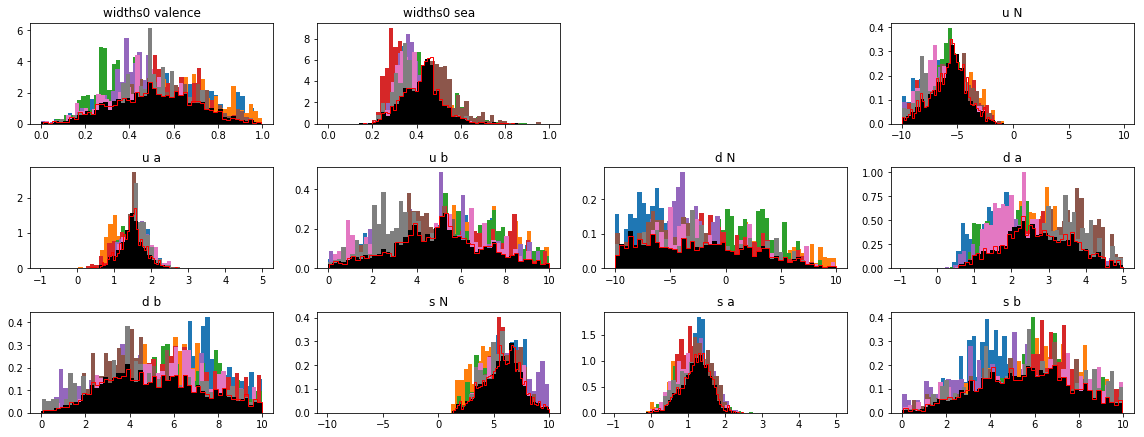

In [19]:
samples=MC['samples']
samples2=MC['samples2']
weights=MC['weights']
weights2=MC['weights2']
order=MC['order']
runs=MC['runs']

nrows,ncols=10,4
fig = py.figure(figsize=(ncols*4,nrows*2))

def get_idx(key,tag):
    for i in range(len(order)):
        if order[i][1]==key and order[i][2]==tag:
            return i

global cnt
cnt=0
def plot(tags):
    global cnt
    for i in range(1,len(tags)):
        cnt+=1
        if tags[i]==None: continue
        idx=get_idx(tags[0],tags[i])
        ax=py.subplot(nrows,ncols,cnt)
        vmin=np.amin(samples2.T[idx])
        vmax=np.amax(samples2.T[idx])
        R=None#(vmin,vmax)
        for k in runs:
            ax.hist(runs[k]['samples'].T[idx],weights=runs[k]['weights'],bins=50,normed=True,range=R)
        ax.hist(samples.T[idx],weights=weights,bins=50,color='k',normed=True,range=R)
        ax.hist(samples2.T[idx],weights=weights2,bins=50,color='r',histtype='step',normed=True,range=R)
        ax.set_title(tags[i])
        mean=np.einsum('i,i',samples2.T[idx],weights2)
        std=np.einsum('i,i',(samples2.T[idx]-mean)**2,weights2)**0.5
        print '%20s = %10.5f +/- %10.5f'%(tags[i],mean,std)
        #ax.set_xlim(vmin,vmax)
    py.tight_layout()

plot(['boermulders','widths0 valence','widths0 sea',None])
plot(['boermulders','u N','u a','u b'])
plot(['boermulders','d N','d a','d b'])
plot(['boermulders','s N','s a','s b'])

In [20]:
def lprint(msg):
    sys.stdout.write('\r')
    sys.stdout.write('%s' %msg)
    sys.stdout.flush()

In [21]:
data={'weights':MC['weights2']}
cnt=0
for s in MC['samples2']:
    cnt+=1    
    lprint('%d/%d'%(cnt,len(MC['samples2'])))  
    conf['resman'].get_residuals(s);
    for k in conf['resman'].sidisres.tabs:
        if k  not in data: data[k]=[]
        thy=conf['resman'].sidisres.tabs[k]['thy']    
        norm=conf['datasets']['sidis']['norm'][k]['value']
        shift=conf['resman'].sidisres.tabs[k]['shift']        
        data[k].append(shift+thy/norm)
save(data,'%s/%s'%(path2results,'sidis.dat'))   

1649/1649

In [22]:
data=load('%s/%s'%(path2results,'sidis.dat'))   
for k in data: data[k]=np.array(data[k])
thy,dthy={},{}
for k in data:
    if k=='weights': continue
    thy[k]=np.einsum('i,ik->k',data['weights'],data[k])
    dthy[k]=np.einsum('i,ik->k',data['weights'],(data[k]-thy[k])**2)**0.5
for k in thy: 
    conf['resman'].sidisres.tabs[k]['thy']=copy.copy(thy[k])
    conf['resman'].sidisres.tabs[k]['dthy']=copy.copy(dthy[k])

In [23]:
report=conf['resman'].gen_report(verb=0,level=1)
delimiters=[]
for i in range(len(report)): 
    if 'reaction:' in report[i]: 
        delimiters.append(i) 

data={}
nlines=len(report)
for i in range(len(delimiters)):
    ini=delimiters[i]
    if i==len(delimiters)-1: fin=len(report)
    else: fin=delimiters[i+1]
    reaction=report[ini].replace('reaction:','').strip()
    data[reaction]={'raw data':report[ini:fin]}
    
for k in data:
    print k
    block=data[k]['raw data']
    isep=[i for i in range(len(block)) if '--------' in block[i]][0]
    data[k]['summary']=[block[i] for i in range(isep)]
    data[k]['tables']=[block[i] for i in range(isep+1,len(block))]

    tabs={}
    for l in data[k]['tables']:
        info=l.split(',')
        col=[s for s in info if 'col' in s][0].split('=')[1].strip()
        if col not in tabs: tabs[col]={}
        info=[[ss.strip() for ss in s.split('=')] for s in info if 'col' not in info  if s.strip()!='']
        
        for s in info:
            if s[0] not in tabs[col]: tabs[col][s[0]]=[]
        
        for s in info:
            try:
                value=float(s[1])
            except:
                value=s[1]
            tabs[col][s[0]].append(value)        

    data[k]['tabs']=tabs
save(data,'%s/%s'%(path2results,'data_and_thy.dat'))

sidis


In [24]:
def summary():
    for k in data:
        print ""
        for l in data[k]['summary']: print l
summary()


reaction: sidis
    idx        tar        had        col        obs  npts       chi2      rchi2      nchi2
   5024   deuteron        pi+     HERMES    AUUcos2     9       8.96       0.00       0.00
   5019     proton        pi-     HERMES    AUUcos2     4       6.68       0.00       0.00
   5020     proton        pi+     HERMES    AUUcos2     9      23.32       0.00       0.00
   5023   deuteron        pi-     HERMES    AUUcos2     4       8.77       0.00       0.00


In [25]:
data = {}

for key, value in conf['resman'].sidisres.tabs.iteritems():
    data[key] = pd.DataFrame(value)

In [29]:
all_data = pd.concat(data.values())

### Plot Data vs. Theory

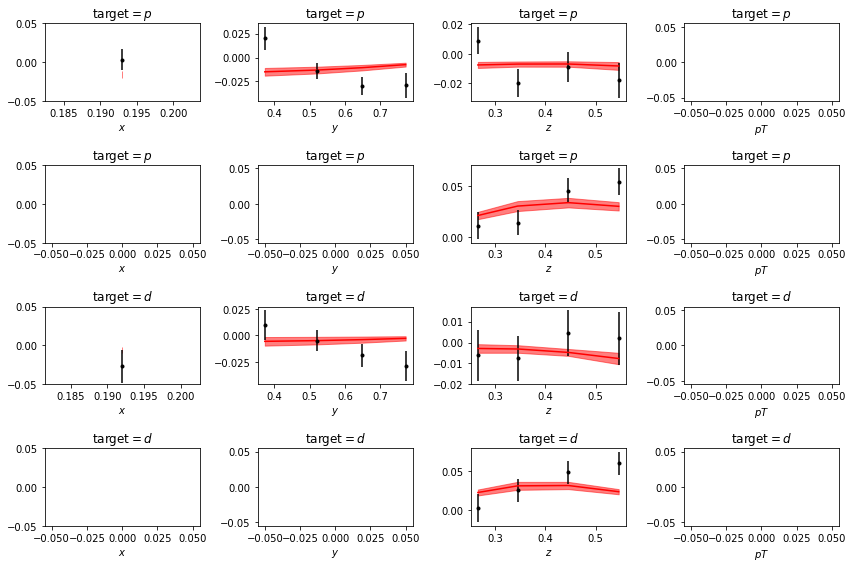

In [32]:
def plot(data,ax,axis,tar,had):
    data=data.query('axis=="%s" and target=="%s" and hadron=="%s" '%(axis,tar,had))
    if axis=='pt': axis='pT'
    ax.errorbar(data[axis],data['value'],yerr=data['alpha'],fmt='k.')
    ax.plot(data[axis],data.thy,'r-')
    ax.fill_between(data[axis], data.thy-data.dthy, data.thy+data.dthy, color='red', alpha=0.5)
    if tar=='proton': star='p'
    if tar=='deuteron': star='d'
    if had=='pi+': shad=r'\pi^+'
    if had=='pi-': shad=r'\pi^-'
    ax.set_title(r'${\rm target}=%s~~{\rm had}=%s$'%(star,shad))
    ax.set_xlabel(r'$%s$'%axis)
    if axis=='x': ax.set_ylim(-0.05,0.05)

nrows,ncols=4,4
py.figure(figsize=(ncols*3,nrows*2))

cnt=0
for tar in ['proton','deuteron']:
    for had in ['pi+','pi-']:
        for axis  in ['x','y','z','pt']:
            cnt+=1
            ax=py.subplot(nrows,ncols,cnt)
            plot(all_data,ax,axis,tar,had)
py.tight_layout()
plt.savefig('/home/dmriser/Pictures/boermulders-hermes-obs.pdf', bbox_inches='tight')